In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LassoLarsCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import maxabs_scale
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.model_selection import train_test_split

from collections import deque

%matplotlib inline

In [2]:
# random state
rs = 4

# Data

Gathering and preparation of the data to be inputed into the model.

The countries were selected in the EDA file, populations were taken from https://worldpopulationreview.com/countries.

In [3]:
# Spain, UK, Italy, Germany...
cc_dict = {
    'ARG': 'Argentina', 'AUS': 'Australia',  
    'CHN': 'China',     'CZE': 'Czechia',    
    'EGY': 'Egypt',     'FIN': 'Finland',
    'HND': 'Honduras',  'IND': 'India',
    'JPN': 'Japan',     'NOR': 'Norway',
    'RUS': 'Russia',    'SWE': 'Sweden',
    'THA': 'Thailand',  'USA': 'US'
}

# cc_dict = {
#     'BEL': 'Belgium',      'CMR': 'Cameroon',    'DOM': 'Dominican Republic',
#     'EGY': 'Egypt',        'IRQ': 'Iraq',        'JOR': 'Jordan',
#     'MLI': 'Mali',         'MWI': 'Malawi',      'NLD': 'Netherlands',
#     'POL': 'Poland',       'SSD': 'South Sudan', 'TUN': 'Tunisia',
#     'ZAF': 'South Africa', 'ZMB': 'Zambia',      'ZWE': 'Zimbabwe'
# }

pop_dict = { # 2020 population
    'ARG': 45195774,   'AUS': 25499884, 
    'CHN': 1439323776, 'CZE': 10708981,   
    'EGY': 102334404,  'FIN': 5540720,  
    'HND': 9904607,    'IND': 1380004385, 
    'JPN': 126476461,  'NOR': 5421241,  
    'RUS': 145934462,  'SWE': 10099265,
    'THA': 69799978,   'USA': 331002651
}

# pop_dict = {
#     'BEL': 11589623,  'CMR': 26545863, 'DOM': 10847910,
#     'EGY': 102334404, 'IRQ': 40222493, 'JOR': 10203134,
#     'MLI': 20250833,  'MWI': 19129952, 'NLD': 17134872,
#     'POL': 37846611,  'SSD': 11193725, 'TUN': 11818619,
#     'ZAF': 59308690,  'ZMB': 18383955, 'ZWE': 14862924
# }

# pd.read_html('https://worldpopulationreview.com/countries', header=0, index_col=1)[0].reindex(cc_dict.values())

## Virus

Virus propagation data is obtained from the CSSE at Johns Hopkins University.

In [4]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recov = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [5]:
jhu_cases = pd.read_csv(url_cases)
jhu_cases.shape

(279, 634)

In [6]:
jhu_death = pd.read_csv(url_death)
jhu_death.shape

(279, 634)

In [7]:
jhu_recov = pd.read_csv(url_recov)
jhu_recov.shape

(264, 634)

Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level.

This is shown for the `cases` data set, but it happens in the three of them.

In [8]:
jhu_cases[jhu_cases['Country/Region'] == 'Australia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,9/13/21,9/14/21,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21,9/29/21,9/30/21,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,10/8/21,10/9/21,10/10/21,10/11/21,10/12/21
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,483,498,509,528,548,563,587,602,617,630,652,665,680,710,725,742,749,765,782,798,817,849,874,893,906,928,959,1011,1063,1101,1129,1162,1190,1231,1271,1296,1326,1358,1386,1437
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,32323,33792,35064,36267,37724,39108,40616,42219,43436,44674,45782,47007,48341,49611,50919,51986,52922,53898,54919,55962,56988,57983,58931,59709,60561,61420,62353,63212,64014,64668,65279,65876,66456,67024,67669,68246,68712,69205,69552,69993
10,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,202,202,202,203,203,203,203,203,203,203,203,203,204,204,204,204,206,206,206,208,208,208,208,209,209,210,211,211,212,212,212,212,212,212,213,214,214,215,215,216
11,Queensland,Australia,-27.4698,153.0251,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...,1984,1985,1991,1991,1991,1992,1995,2002,2003,2007,2009,2010,2013,2014,2015,2015,2017,2018,2019,2021,2021,2022,2022,2022,2028,2029,2035,2039,2042,2043,2046,2048,2051,2056,2056,2059,2062,2063,2067,2067
12,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,877,879,880,881,888,889,891,891,892,894,895,896,896,898,898,898,898,898,898,899,900,900,900,901,901,901,901,901,902,904,905,906,907,907,907,908,909,910,913,914
13,Tasmania,Australia,-42.8821,147.3272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,236,236,236,236,236,236,236,236,236,236,236
14,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,22759,22942,23188,23429,23641,23964,24297,24747,25128,25591,26036,26439,26942,27439,27968,28456,29008,29596,30216,30961,31679,32515,33294,33967,34975,35904,37333,38476,39952,41128,42505,44251,45664,47266,49104,51012,52902,54470,55936,57470
15,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1086,1086,1086,1087,1087,1088,1088,1088,1089,1089,1089,1089,1089,1089,1092,1092,1093,1094,1094,1094,1094,1095,1095,1095,1096,1096,1096,1096,1096,1096,1099,1109,1110,1110,1110,1110,1110,1110,1110,1111


In [9]:
jhu_cases[jhu_cases['Country/Region'] == 'Netherlands']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,9/13/21,9/14/21,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21,9/29/21,9/30/21,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,10/8/21,10/9/21,10/10/21,10/11/21,10/12/21
193,Aruba,Netherlands,12.5211,-69.9683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14764,14812,14812,14861,14913,14955,14991,15022,15057,15076,15092,15129,15155,15177,15202,15221,15249,15274,15305,15305,15351,15370,15405,15416,15432,15448,15472,15500,15514,15533,15536,15543,15560,15578,15587,15605,15626,15626,15645,15663
194,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1808,1819,1837,1850,1863,1885,1895,1908,1928,1932,1932,1945,1949,1956,1962,1969,1972,1974,1980,1988,1998,2003,2010,2019,2045,2068,2083,2096,2116,2126,2141,2157,2168,2184,2204,2217,2217,2235,2257,2274
195,Curacao,Netherlands,12.1696,-68.9900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15413,15452,15470,15483,15506,15550,15596,15642,15696,15713,15741,15814,15867,15925,15975,16031,16056,16086,16150,16216,16254,16303,16339,16373,16383,16428,16465,16500,16556,16592,16609,16618,16650,16684,16704,16742,16777,16787,16804,16837
196,Sint Maarten,Netherlands,18.0425,-63.0548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3797,3824,3824,3849,3888,3921,3947,3947,3969,3979,3999,4021,4021,4053,4070,4070,4091,4117,4146,4161,4178,4197,4213,4213,4235,4263,4263,4283,4291,4307,4321,4342,4342,4355,4386,4395,4395,4403,4403,4420
197,NaN,Netherlands,52.1326,5.2913,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1949195,1951886,1954233,1956348,1958804,1961585,1963947,1966634,1968832,1968832,1972653,1974662,1977016,1979114,1981252,1983252,1984915,1986241,1987905,1989805,1991628,1993309,1994901,1996498,1997885,1999592,2001347,2003050,2004763,2006421,2008024,2009648,2011530,2013425,2016171,2018932,2021433,2023691,2026402,2029289


Canada does not have recovery data available at province-level.

In [10]:
jhu_cases['Country/Region'].value_counts().head(9)

China             34
Canada            16
United Kingdom    12
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Saudi Arabia       1
Name: Country/Region, dtype: int64

In [11]:
jhu_death['Country/Region'].value_counts().head(9)

China             34
Canada            16
United Kingdom    12
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Saudi Arabia       1
Name: Country/Region, dtype: int64

In [12]:
jhu_recov['Country/Region'].value_counts().head(9)

China             34
United Kingdom    12
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Cuba               1
Cabo Verde         1
Name: Country/Region, dtype: int64

Remove global registries from countries with subregional registies and the sum up these subregional cases.

In [13]:
sel_reg = ['Netherlands', 'United Kingdom', 'France', 'Denmark']

def remove_global_registry(jhu_df):
  'Remove global country records when local ones exist.'
  a = jhu_df['Country/Region'].isin(sel_reg)
  b = jhu_df['Province/State'].isna()
  cond = pd.DataFrame([a, b]).all()
  idx = jhu_df[cond].index
  jhu_df.drop(idx, axis=0, inplace=True)

# remove global Netherlands, UK, France and Denmark
remove_global_registry(jhu_cases)
remove_global_registry(jhu_death)
remove_global_registry(jhu_recov)
# drop subregion, latitude and longitude columns
jhu_cases.drop(jhu_cases.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_death.drop(jhu_death.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_recov.drop(jhu_recov.columns[[0, 2, 3]], axis=1, inplace=True)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (275, 631)
deaths shape: (275, 631)
recoveries shape: (260, 631)


In [14]:
# reshape dfs
jhu_cases = jhu_cases.groupby('Country/Region').sum()
jhu_cases = jhu_cases.T # transpose columns / rows
jhu_cases.index = pd.to_datetime(jhu_cases.index)
jhu_death = jhu_death.groupby('Country/Region').sum()
jhu_death = jhu_death.T # transpose columns / rows
jhu_death.index = pd.to_datetime(jhu_death.index)
jhu_recov = jhu_recov.groupby('Country/Region').sum()
jhu_recov = jhu_recov.T # transpose columns / rows
jhu_recov.index = pd.to_datetime(jhu_recov.index)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (630, 195)
deaths shape: (630, 195)
recoveries shape: (630, 195)


Create separate dataframes containing data on countries of interest only. Apply a smoothing average to the curves. Use them to compute further variables (compartments) needed to represent the compartmental model.

In [15]:
window = 5

In [16]:
cum_cases = jhu_cases[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_cases

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.00,0.000000,703.666667,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,2.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.333333e+00,1.333333e+00
2020-01-23,0.00,0.000000,879.250000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,2.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.750000e+00,1.500000e+00
2020-01-24,0.00,0.800000,1118.400000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,2.400000e+00,0.000000,0.000000e+00,0.000000e+00,5.400000e+00,2.200000e+00
2020-01-25,0.00,1.800000,1584.200000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,2.800000e+00,0.000000,0.000000e+00,0.000000e+00,6.200000e+00,3.000000e+00
2020-01-26,0.00,2.800000,2557.400000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,3.800000e+00,0.000000,0.000000e+00,0.000000e+00,8.200000e+00,3.800000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,5264793.80,124945.400000,108707.600000,1.697992e+06,310760.600000,145411.2,369030.000000,3.393405e+07,1.710325e+06,192911.400000,7.603422e+06,1.157359e+06,1.691396e+06,4.423302e+07
2021-10-09,5265405.00,127220.000000,108732.800000,1.698804e+06,311585.400000,145937.6,369276.400000,3.395238e+07,1.711024e+06,193242.400000,7.631145e+06,1.157674e+06,1.699921e+06,4.431244e+07
2021-10-10,5266011.80,129395.600000,108757.400000,1.700192e+06,312421.800000,146450.6,369664.000000,3.396961e+07,1.711651e+06,193651.000000,7.658975e+06,1.158170e+06,1.710334e+06,4.439311e+07
2021-10-11,5266250.25,130474.250000,108770.750000,1.700724e+06,312841.000000,146643.5,369822.500000,3.397819e+07,1.711958e+06,193800.250000,7.673122e+06,1.158256e+06,1.715558e+06,4.441888e+07


In [17]:
cum_deaths = jhu_death[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,20.333333,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
2020-01-23,0.000000,0.000000,25.750000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
2020-01-24,0.000000,0.000000,31.800000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
2020-01-25,0.000000,0.000000,44.800000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
2020-01-26,0.000000,0.000000,67.400000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,115434.000000,1419.000000,4849.000000,30494.800000,17620.200000,1093.800000,9948.200000,450345.80,17904.000000,871.0,210694.000000,14901.60,17533.6,711288.400000
2021-10-09,115456.400000,1433.400000,4849.000000,30498.600000,17656.400000,1096.000000,9960.200000,450567.20,17931.800000,871.0,211630.000000,14904.80,17600.2,712477.400000
2021-10-10,115482.600000,1448.000000,4849.000000,30502.400000,17692.600000,1099.400000,9979.400000,450779.60,17957.200000,871.0,212574.800000,14908.00,17683.6,713671.200000
2021-10-11,115492.250000,1454.750000,4849.000000,30504.000000,17711.000000,1100.250000,9987.250000,450880.75,17967.000000,871.0,213050.250000,14908.75,17721.0,714004.250000


In [18]:
cum_recoveries = jhu_recov[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.0,0.0,31.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0
2020-01-23,0.0,0.0,33.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000,0.0
2020-01-24,0.0,0.0,36.400000,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,3.200000,0.0
2020-01-25,0.0,0.0,42.400000,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,4.000000,0.0
2020-01-26,0.0,0.0,56.600000,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,4.800000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2021-10-09,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2021-10-10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2021-10-11,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [19]:
print('Total number of missing values in')
print(' - cases:', cum_cases.isna().sum().sum())
print(' - deaths:', cum_deaths.isna().sum().sum())
print(' - recoveries:', cum_recoveries.isna().sum().sum())

Total number of missing values in
 - cases: 0
 - deaths: 0
 - recoveries: 0


In [20]:
R = cum_deaths + cum_recoveries
R

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,51.666667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,2.333333,0.000000
2020-01-23,0.000000,0.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,2.500000,0.000000
2020-01-24,0.000000,0.000000,68.200000,0.000000,0.000000,0.000000,0.000000,0.00,0.200000,0.0,0.000000,0.00,3.200000,0.000000
2020-01-25,0.000000,0.000000,87.200000,0.000000,0.000000,0.000000,0.000000,0.00,0.400000,0.0,0.000000,0.00,4.000000,0.000000
2020-01-26,0.000000,0.000000,124.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.600000,0.0,0.000000,0.00,4.800000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,115434.000000,1419.000000,4849.000000,30494.800000,17620.200000,1093.800000,9948.200000,450345.80,17904.000000,871.0,210694.000000,14901.60,17533.600000,711288.400000
2021-10-09,115456.400000,1433.400000,4849.000000,30498.600000,17656.400000,1096.000000,9960.200000,450567.20,17931.800000,871.0,211630.000000,14904.80,17600.200000,712477.400000
2021-10-10,115482.600000,1448.000000,4849.000000,30502.400000,17692.600000,1099.400000,9979.400000,450779.60,17957.200000,871.0,212574.800000,14908.00,17683.600000,713671.200000
2021-10-11,115492.250000,1454.750000,4849.000000,30504.000000,17711.000000,1100.250000,9987.250000,450880.75,17967.000000,871.0,213050.250000,14908.75,17721.000000,714004.250000


In [21]:
I = cum_cases - R
I

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000e+00,0.0,652.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,0.0,0.000000e+00,2.000000e+00,1.333333e+00
2020-01-23,0.000000e+00,0.0,820.250000,0.0,0.0,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,0.0,0.000000e+00,2.250000e+00,1.500000e+00
2020-01-24,0.000000e+00,0.8,1050.200000,0.0,0.0,0.000000,0.000000,0.000000e+00,2.200000e+00,0.000000,0.0,0.000000e+00,2.200000e+00,2.200000e+00
2020-01-25,0.000000e+00,1.8,1497.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,2.400000e+00,0.000000,0.0,0.000000e+00,2.200000e+00,3.000000e+00
2020-01-26,0.000000e+00,2.8,2433.400000,0.0,0.0,0.000000,0.000000,0.000000e+00,3.200000e+00,0.000000,0.0,0.000000e+00,3.400000e+00,3.800000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,5.149360e+06,123526.4,103858.600000,1667496.8,293140.4,144317.400000,359081.800000,3.348371e+07,1.692421e+06,192040.400000,7392728.4,1.142458e+06,1.673863e+06,4.352173e+07
2021-10-09,5.149949e+06,125786.6,103883.800000,1668305.4,293929.0,144841.600000,359316.200000,3.350181e+07,1.693092e+06,192371.400000,7419515.4,1.142769e+06,1.682321e+06,4.359996e+07
2021-10-10,5.150529e+06,127947.6,103908.400000,1669689.4,294729.2,145351.200000,359684.600000,3.351883e+07,1.693694e+06,192780.000000,7446400.2,1.143262e+06,1.692651e+06,4.367944e+07
2021-10-11,5.150758e+06,129019.5,103921.750000,1670220.5,295130.0,145543.250000,359835.250000,3.352731e+07,1.693990e+06,192929.250000,7460072.0,1.143348e+06,1.697838e+06,4.370487e+07


In [22]:
S = pop_dict.values() - cum_cases
S

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,45195774.00,2.549988e+07,1.439323e+09,1.070898e+07,1.023344e+08,5540720.0,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-23,45195774.00,2.549988e+07,1.439323e+09,1.070898e+07,1.023344e+08,5540720.0,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-24,45195774.00,2.549988e+07,1.439323e+09,1.070898e+07,1.023344e+08,5540720.0,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-25,45195774.00,2.549988e+07,1.439322e+09,1.070898e+07,1.023344e+08,5540720.0,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-26,45195774.00,2.549988e+07,1.439321e+09,1.070898e+07,1.023344e+08,5540720.0,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,39930980.20,2.537494e+07,1.439215e+09,9.010989e+06,1.020236e+08,5395308.8,9.535577e+06,1.346070e+09,1.247661e+08,5.228330e+06,1.383310e+08,8.941906e+06,6.810858e+07,2.867696e+08
2021-10-09,39930369.00,2.537266e+07,1.439215e+09,9.010177e+06,1.020228e+08,5394782.4,9.535331e+06,1.346052e+09,1.247654e+08,5.227999e+06,1.383033e+08,8.941591e+06,6.810006e+07,2.866902e+08
2021-10-10,39929762.20,2.537049e+07,1.439215e+09,9.008789e+06,1.020220e+08,5394269.4,9.534943e+06,1.346035e+09,1.247648e+08,5.227590e+06,1.382755e+08,8.941095e+06,6.808964e+07,2.866095e+08
2021-10-11,39929523.75,2.536941e+07,1.439215e+09,9.008256e+06,1.020216e+08,5394076.5,9.534784e+06,1.346026e+09,1.247645e+08,5.227441e+06,1.382613e+08,8.941008e+06,6.808442e+07,2.865838e+08


In [23]:
r_prop = R / pop_dict.values()
i_prop = I / pop_dict.values()
s_prop = S / pop_dict.values()

In [24]:
r_prop.agg(['min', 'max'])

,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.000000,0.000000,3.589649e-08,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.342885e-08,0.000000
max,0.103984,0.000983,7.226949e-05,0.156056,0.002422,0.00848,0.011017,0.022697,0.006788,0.003467,0.039272,0.001476,4.590202e-04,0.019364


In [25]:
i_prop.agg(['min', 'max'])

,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.000000,0.000000,7.114452e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.581322e-08,0.00000,0.000000,0.000000,2.865330e-08,4.028165e-09
max,0.113971,0.005099,7.220984e-05,0.156016,0.002888,0.026326,0.036355,0.024301,1.339564e-02,0.03562,0.051212,0.113225,2.439776e-02,1.321385e-01


In [26]:
s_prop.agg(['min', 'max'])

,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.883474,0.994844,0.999924,0.841136,0.996939,0.973475,0.962635,0.975372,0.986462,0.964219,0.947325,0.885298,0.975348,0.865703
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Initial approximation

Operate with the proportional compartments; $s, i, r$. Analyse the beginning of the pandemic, assuming $\lim_{t\rightarrow0}s\rightarrow1$. Therefore, study the change of the growth rate $gr=\log{i_2}-\log{i_1}=\beta-\gamma$.

In [27]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0
log_i

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,-14.607395,0.000000,0.000000,0.000000,0.000000,0.000000,-17.962420,0.000000,0.000000,0.000000,-17.367997,-19.329955
2020-01-23,0.000000,0.000000,-14.377830,0.000000,0.000000,0.000000,0.000000,0.000000,-17.962420,0.000000,0.000000,0.000000,-17.250214,-19.212172
2020-01-24,0.000000,-17.277328,-14.130703,0.000000,0.000000,0.000000,0.000000,0.000000,-17.867109,0.000000,0.000000,0.000000,-17.272687,-18.829180
2020-01-25,0.000000,-16.466398,-13.776221,0.000000,0.000000,0.000000,0.000000,0.000000,-17.780098,0.000000,0.000000,0.000000,-17.272687,-18.519025
2020-01-26,0.000000,-16.024565,-13.290395,0.000000,0.000000,0.000000,0.000000,0.000000,-17.492416,0.000000,0.000000,0.000000,-16.837369,-18.282636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,-2.172131,-5.329974,-9.536654,-1.859759,-5.855350,-3.647865,-3.317205,-3.718783,-4.313896,-3.340374,-2.982661,-2.179281,-3.730500,-2.028866
2021-10-09,-2.172017,-5.311842,-9.536411,-1.859274,-5.852663,-3.644239,-3.316553,-3.718243,-4.313500,-3.338652,-2.979044,-2.179008,-3.725460,-2.027070
2021-10-10,-2.171904,-5.294808,-9.536174,-1.858445,-5.849944,-3.640727,-3.315528,-3.717735,-4.313144,-3.336530,-2.975427,-2.178577,-3.719338,-2.025249
2021-10-11,-2.171860,-5.286466,-9.536046,-1.858127,-5.848585,-3.639406,-3.315109,-3.717482,-4.312969,-3.335756,-2.973593,-2.178502,-3.716278,-2.024667


In [28]:
gr = log_i[1:] - log_i[:-1].values # different index
gr

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,0.000000,0.229565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117783,0.117783
2020-01-24,0.000000,-17.277328,0.247127,0.000000,0.000000,0.000000,0.000000,0.000000,0.095310,0.000000,0.000000,0.000000,-0.022473,0.382992
2020-01-25,0.000000,0.810930,0.354482,0.000000,0.000000,0.000000,0.000000,0.000000,0.087011,0.000000,0.000000,0.000000,0.000000,0.310155
2020-01-26,0.000000,0.441833,0.485826,0.000000,0.000000,0.000000,0.000000,0.000000,0.287682,0.000000,0.000000,0.000000,0.435318,0.236389
2020-01-27,0.000000,0.356675,0.342863,0.000000,0.000000,-17.137073,0.000000,0.000000,0.223144,0.000000,0.000000,0.000000,0.302281,0.191055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,0.000147,0.019079,0.000268,0.000578,0.002650,0.002314,0.000189,0.000588,0.000485,0.002036,0.003518,0.000396,0.006373,0.001771
2021-10-09,0.000114,0.018132,0.000243,0.000485,0.002687,0.003626,0.000653,0.000540,0.000396,0.001722,0.003617,0.000273,0.005040,0.001796
2021-10-10,0.000113,0.017034,0.000237,0.000829,0.002719,0.003512,0.001025,0.000508,0.000355,0.002122,0.003617,0.000431,0.006122,0.001821
2021-10-11,0.000044,0.008343,0.000128,0.000318,0.001359,0.001320,0.000419,0.000253,0.000175,0.000774,0.001834,0.000075,0.003060,0.000582


### Transmission coefficient computation

Operate with the relative compartments to save operations. Only assuming independence with time (same as last time), study $\beta=\frac{gr+\gamma}{S}$.

Because the SIR model (instead of the SEIR model) is being used, the resulting transmission coefficient will be small.

In [29]:
dr_dt = r_prop[1:] - r_prop[:-1].values # different index
dr_dt

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000e+00,0.000000e+00,5.094985e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.387775e-09,0.000000
2020-01-24,0.000000e+00,0.000000e+00,6.391891e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.581322e-09,0.000000e+00,0.000000,0.000000e+00,1.002866e-08,0.000000
2020-01-25,0.000000e+00,0.000000e+00,1.320064e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.581322e-09,0.000000e+00,0.000000,0.000000e+00,1.146132e-08,0.000000
2020-01-26,0.000000e+00,0.000000e+00,2.556756e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.581322e-09,0.000000e+00,0.000000,0.000000e+00,1.146132e-08,0.000000
2020-01-27,0.000000e+00,0.000000e+00,2.654024e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.581322e-09,0.000000e+00,0.000000,0.000000e+00,8.595991e-09,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,6.637789e-07,5.411789e-07,0.000000e+00,3.361664e-07,3.654685e-07,4.331567e-07,7.269344e-07,1.802893e-07,2.292917e-07,3.689192e-07,0.000006,5.742992e-07,1.398281e-06,0.000004
2021-10-09,4.956216e-07,5.647085e-07,0.000000e+00,3.548424e-07,3.537422e-07,3.970603e-07,1.211557e-06,1.604343e-07,2.198037e-07,0.000000e+00,0.000006,3.168547e-07,9.541550e-07,0.000004
2021-10-10,5.797002e-07,5.725516e-07,0.000000e+00,3.548424e-07,3.537422e-07,6.136387e-07,1.938492e-06,1.539126e-07,2.008279e-07,0.000000e+00,0.000006,3.168547e-07,1.194843e-06,0.000004
2021-10-11,2.135155e-07,2.647071e-07,0.000000e+00,1.494073e-07,1.798027e-07,1.534097e-07,7.925605e-07,7.329687e-08,7.748477e-08,0.000000e+00,0.000003,7.426283e-08,5.358168e-07,0.000001


In [30]:
gamma = dr_dt / i_prop[1:]
gamma[np.isinf(gamma)] = np.nan # division by zero
gamma[gamma.isna()] = 0         # before the pandemic begins
gamma

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,0.000000,0.008940,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.074074,0.000000
2020-01-24,0.000000,0.000000,0.008760,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.090909,0.00000,0.000000,0.000000e+00,0.318182,0.000000
2020-01-25,0.000000,0.000000,0.012692,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.083333,0.00000,0.000000,0.000000e+00,0.363636,0.000000
2020-01-26,0.000000,0.000000,0.015123,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.062500,0.00000,0.000000,0.000000e+00,0.235294,0.000000
2020-01-27,0.000000,0.000000,0.011142,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.050000,0.00000,0.000000,0.000000e+00,0.130435,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,0.000006,0.000112,0.000000,2.158925e-06,0.000128,0.000017,0.000020,0.000007,0.000017,0.00001,0.000126,5.076774e-06,0.000058,0.000034
2021-10-09,0.000004,0.000114,0.000000,2.277760e-06,0.000123,0.000015,0.000033,0.000007,0.000016,0.00000,0.000126,2.800215e-06,0.000040,0.000027
2021-10-10,0.000005,0.000114,0.000000,2.275872e-06,0.000123,0.000023,0.000053,0.000006,0.000015,0.00000,0.000127,2.799009e-06,0.000049,0.000027
2021-10-11,0.000002,0.000052,0.000000,9.579573e-07,0.000062,0.000006,0.000022,0.000003,0.000006,0.00000,0.000064,6.559684e-07,0.000022,0.000008


In [31]:
beta = (gr + gamma) / s_prop[1:]
beta

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,0.000000,0.238505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.191857,0.117783
2020-01-24,0.000000,-17.277329,0.255887,0.000000,0.000000,0.000000,0.000000,0.000000,0.186219,0.000000,0.000000,0.000000,0.295709,0.382992
2020-01-25,0.000000,0.810930,0.367175,0.000000,0.000000,0.000000,0.000000,0.000000,0.170345,0.000000,0.000000,0.000000,0.363636,0.310155
2020-01-26,0.000000,0.441833,0.500950,0.000000,0.000000,0.000000,0.000000,0.000000,0.350182,0.000000,0.000000,0.000000,0.670612,0.236389
2020-01-27,0.000000,0.356675,0.354005,0.000000,0.000000,-17.137074,0.000000,0.000000,0.273144,0.000000,0.000000,0.000000,0.432716,0.191055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,0.000173,0.019285,0.000268,0.000689,0.002786,0.002394,0.000218,0.000611,0.000509,0.002122,0.003844,0.000452,0.006591,0.002082
2021-10-09,0.000134,0.018338,0.000243,0.000579,0.002818,0.003739,0.000713,0.000561,0.000418,0.001786,0.003950,0.000311,0.005207,0.002105
2021-10-10,0.000133,0.017236,0.000237,0.000988,0.002850,0.003632,0.001120,0.000527,0.000376,0.002200,0.003951,0.000490,0.006326,0.002135
2021-10-11,0.000052,0.008438,0.000128,0.000379,0.001426,0.001362,0.000458,0.000262,0.000183,0.000803,0.002003,0.000086,0.003159,0.000681


## Policy

We focus on policies aimed at obstructing the spread of the virus. The Oxford group considers four types of measures:

*   Containment
*   Economic
*   Health system
*   Miscellaneous

Here containment- and some health system-related measures are considered.

In [32]:
url_pol = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'

oxcgrt = pd.read_csv(url_pol, dtype={'RegionName': str, 'RegionCode': str})

oxcgrt.drop(oxcgrt.columns[37:], axis=1, inplace=True)    # indexes and extra

oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format='%Y%m%d')
oxcgrt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203424 entries, 0 to 203423
Data columns (total 37 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   CountryName                            203424 non-null  object        
 1   CountryCode                            203424 non-null  object        
 2   RegionName                             82152 non-null   object        
 3   RegionCode                             82152 non-null   object        
 4   Jurisdiction                           203424 non-null  object        
 5   Date                                   203424 non-null  datetime64[ns]
 6   C1_School closing                      197356 non-null  float64       
 7   C1_Flag                                161225 non-null  float64       
 8   C2_Workplace closing                   197315 non-null  float64       
 9   C2_Flag                                153324 no

Policy implementation is available at state level in some countries.

In [33]:
oxcgrt_sub = oxcgrt[oxcgrt['Jurisdiction'] == 'STATE_TOTAL'].copy()
oxcgrt_sub

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people
14996,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
14997,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
14998,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
14999,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
15000,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197551,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197552,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-10-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197553,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-10-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197554,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# region information
oxcgrt.drop(oxcgrt.columns[[2, 3]], axis=1, inplace=True)

oxcgrt = oxcgrt[oxcgrt['Jurisdiction'] == 'NAT_TOTAL']
oxcgrt

,CountryName,CountryCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people
0,Aruba,ABW,NAT_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
1,Aruba,ABW,NAT_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
2,Aruba,ABW,NAT_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
3,Aruba,ABW,NAT_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
4,Aruba,ABW,NAT_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203419,Zimbabwe,ZWE,NAT_TOTAL,2021-10-09,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,2.0,1.0,3.0,1.0,NaN,NaN,3.0,1.0,5.0,1.0,1.0
203420,Zimbabwe,ZWE,NAT_TOTAL,2021-10-10,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,2.0,1.0,3.0,1.0,NaN,NaN,3.0,1.0,5.0,1.0,1.0
203421,Zimbabwe,ZWE,NAT_TOTAL,2021-10-11,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,2.0,1.0,3.0,1.0,NaN,NaN,3.0,1.0,5.0,1.0,1.0
203422,Zimbabwe,ZWE,NAT_TOTAL,2021-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The Oxford dataset contains earlier dates compared to the JHU dataset.

In [35]:
print('Virus data: ', jhu_cases.index.min(), '-', jhu_cases.index.max())
print('Policy data:', oxcgrt['Date'].min(), '-', oxcgrt['Date'].max())

Virus data:  2020-01-22 00:00:00 - 2021-10-12 00:00:00
Policy data: 2020-01-01 00:00:00 - 2021-10-13 00:00:00


Pivot the data to obtain a different dataset for each policy type indexed by time (date).

In [36]:
idch = list(oxcgrt.columns[4:19:2])
idch.append(oxcgrt.columns[24])
idch.append(oxcgrt.columns[30])

C1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[0])
C2 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[1])
C3 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[2])
C4 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[3])
C5 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[4])
C6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[5])
C7 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[6])
C8 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[7])
H1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[8])
H6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[9])

CH_X = [C1, C2, C3, C4, C5, C6, C7, C8, H1, H6]
 
idch

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'H1_Public information campaigns',
 'H6_Facial Coverings']

Correlation of the different containment policy types. Can be used to supress highly correlated policies.

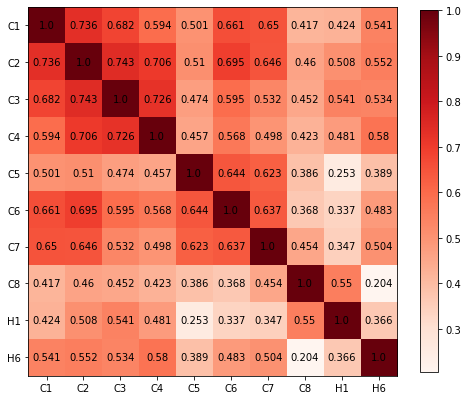

In [37]:
mask = oxcgrt['CountryCode'].isin(cc_dict)
corr = oxcgrt.loc[mask, idch].corr()

# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=corr, cmap='Reds') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# show all ticks...
ax.set_xticks(range(corr.shape[1]))
ax.set_yticks(range(corr.shape[0]))
# ...and label them
[s.split('_')[0] for s in idch]
ax.set_xticklabels([s.split('_')[0] for s in corr.columns])
ax.set_yticklabels([s.split('_')[0] for s in corr.index])
# loop over data dimensions and create text annotations
for i in range(corr.shape[1]):
  for j in range(corr.shape[0]):
    text = ax.text(j, i, round(corr.iloc[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [38]:
print('Missing values per indicator:')
print(' - C1:', C1[cc_dict.keys()].isna().sum().sum())
print(' - C2:', C2[cc_dict.keys()].isna().sum().sum())
print(' - C3:', C3[cc_dict.keys()].isna().sum().sum())
print(' - C4:', C4[cc_dict.keys()].isna().sum().sum())
print(' - C5:', C5[cc_dict.keys()].isna().sum().sum())
print(' - C6:', C6[cc_dict.keys()].isna().sum().sum())
print(' - C7:', C7[cc_dict.keys()].isna().sum().sum())
print(' - C8:', C8[cc_dict.keys()].isna().sum().sum())
print(' - H1:', H1[cc_dict.keys()].isna().sum().sum())
print(' - H6:', H6[cc_dict.keys()].isna().sum().sum())

Missing values per indicator:
 - C1: 114
 - C2: 121
 - C3: 122
 - C4: 134
 - C5: 121
 - C6: 120
 - C7: 121
 - C8: 121
 - H1: 122
 - H6: 120


## Visualizations

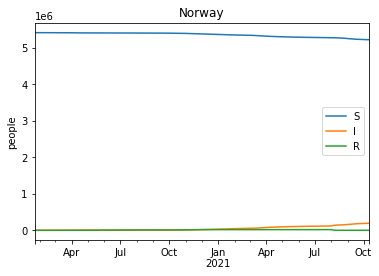

In [39]:
cc_idx = 9
country = list(cc_dict.values())[cc_idx]

S[country].plot()
I[country].plot()
R[country].plot()
plt.ylabel('people')
plt.title(country)
plt.legend(labels=['S', 'I', 'R'])
plt.show()

In [40]:
print('Missing values (NaN) in the response')
print(' - growth rate:', gr.isna().sum().sum())
print(' - transmission rate:', beta.isna().sum().sum())

Missing values (NaN) in the response
 - growth rate: 0
 - transmission rate: 0


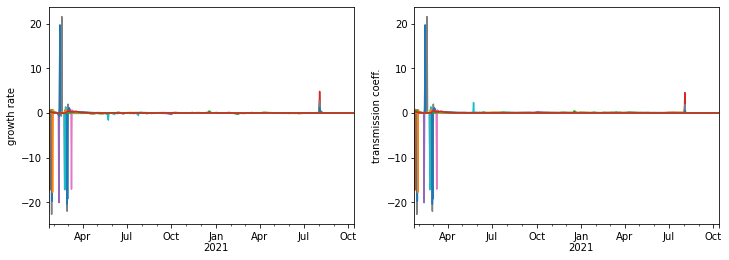

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
gr.plot(legend=False, ax=axs[0])
beta.plot(legend=False, ax=axs[1])
axs[0].set_ylabel('growth rate')
axs[1].set_ylabel('transmission coeff.')
plt.show()

Most countries present spikes at the beginning of the pandemic. Possibly due to reporting concentrations. Furthermore, low populated countries present various spikes.

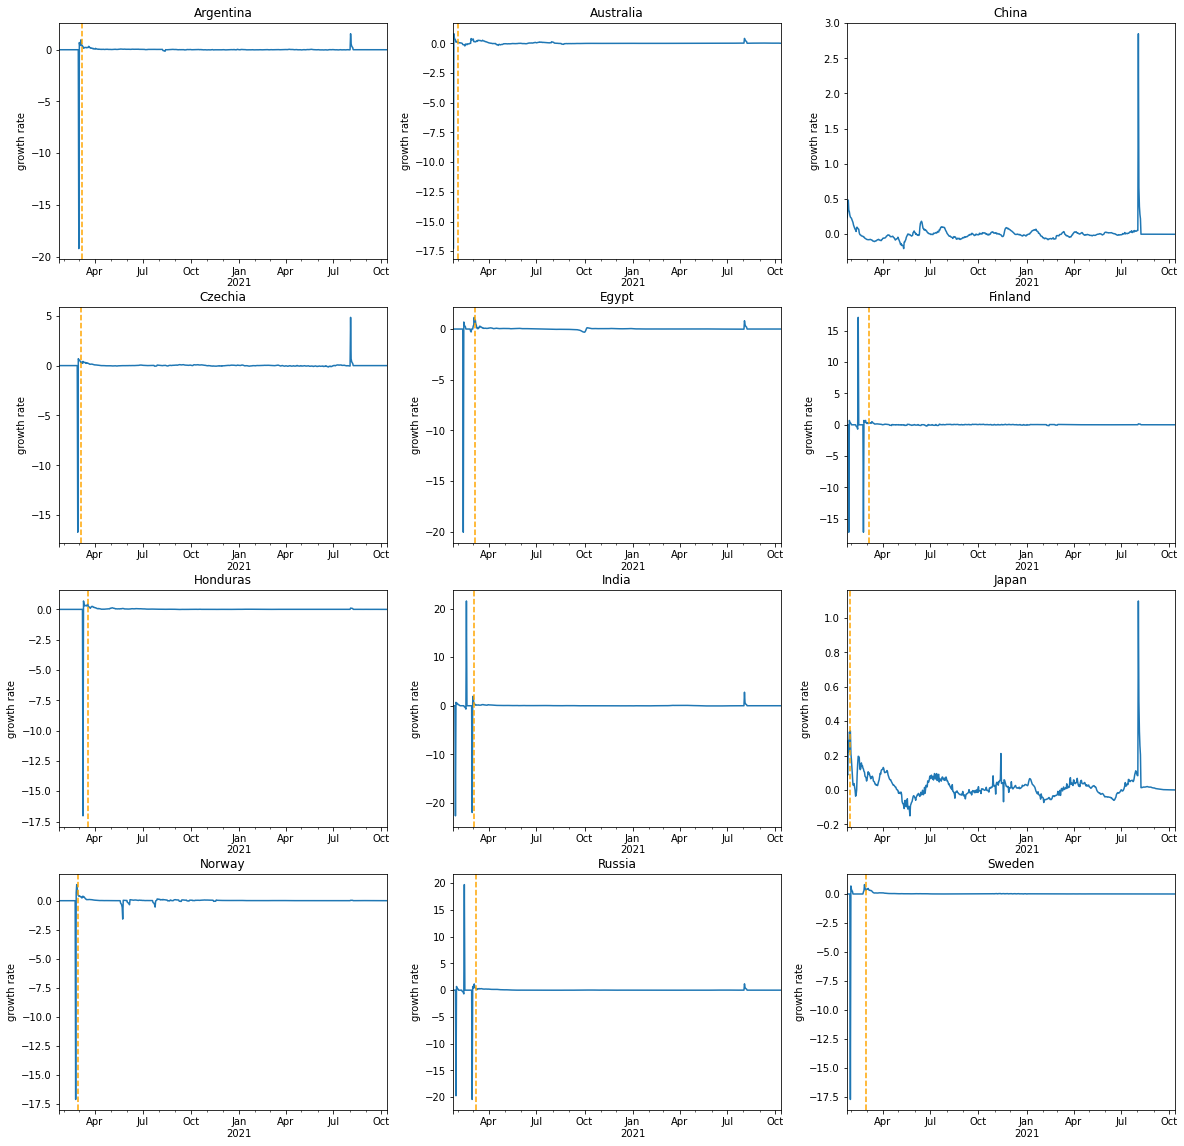

In [42]:
nrows = len(cc_dict) // 3
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname][cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  gr[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('growth rate')

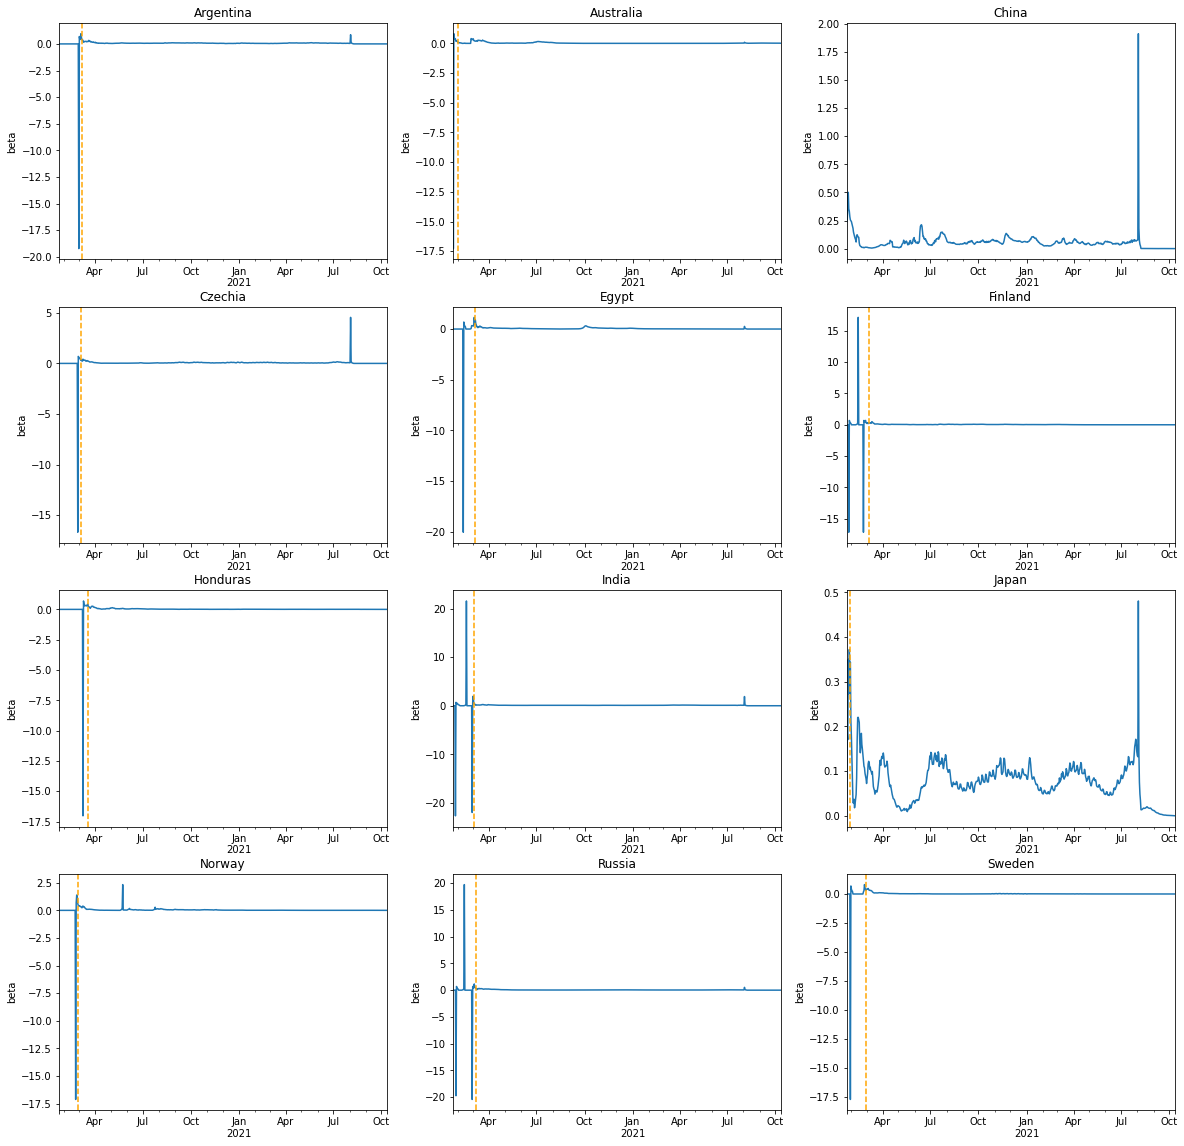

In [43]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname].loc[cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  beta[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('beta')

# Model

Development of the model(s) and results.

## Auxiliar

In [44]:
# aux vars
ta = gr.index.min()
tb = gr.index.max()

chx_str = [s.split('_')[0] for s in idch]

In [45]:
# check starting date
ta == beta.index.min()

True

In [46]:
# aux fns
def _get_init_date(iso):
  name = cc_dict[iso]
  t_idx = cum_cases.loc[cum_cases[name] > 25, name].index
  return t_idx.min()

def data_from(iso, t0, t1, tr, t_d, y):
  'Select data with location and time constraints.'

  if iso in cc_dict.keys():
    name = cc_dict[iso]
  elif iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  if not t0:
    t0 = _get_init_date(iso)
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  
  if not t1:
    if not tr:
      raise ValueError('Provide end of time range (either t1 or tr).')
    prop_case = cum_cases[name] / pop_dict[iso]
    t1 = prop_case[prop_case < tr/100].index.max()

  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

# to do: different for the two labels
def preprocess(pol_t, y_t):
  'Transform data to feed the model.'
  
  pol_t.fillna(method='pad', inplace=True) # back fill
  pol_t.fillna(value=0, inplace=True)      # if no previous value available
  pol_norm = maxabs_scale(pol_t[1:])       # match vars length at scaling
  y_norm = maxabs_scale(y_t)

  # policy combinations
  # poly = PolynomialFeatures(degree=2, interaction_only=True)
  # pol_comb = poly.fit_transform(pol_norm)
  # comb_str = poly.get_feature_names(chx_str)
  # day-of-the-week
  # day = y_t[1:].index.weekday.values.reshape(-1, 1)
  # ohe = OneHotEncoder(sparse=False).fit_transform(day)
  # ohe_str = [f'weekday {d+1}' for d in range(7)]
  # previous 
  td1 = y_norm[:-1].reshape(-1, 1)
  # group data
  arr = np.hstack([pol_norm, td1])
  col = np.append(chx_str, 'prev')
  df = pd.DataFrame(arr, columns=col)

  # label = pd.Series(y_norm[1:], index=y_t[1:].index) # date ref
  
  return df, y_norm[1:]

def _print_model(name, value, score):
  print('Coefficients\n------------')
  for n, v in zip(name, value):
    if v != 0:
      print('{:s} : {:3f}'.format(n, v))
  print('\nR^2\n---')
  print(round(score, 3))

## Initial model

Customized grid of values for the parameters.

Compare the linear regression and Lasso stability of coefficients.

The code is:

```
cv_flag = True
y_df = gr_smooth
cv_arr = []
grid = {'tr': [0.5, 0.75, 1, 2, 3], 'delay': [7, 10, 14, 18, 21]}
lin = LinearRegression()
# lasso = LassoLarsCV(cv=KFold(shuffle=True), max_iter=3, eps=.1**7)
# lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**5)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    cv_par = []
    X_raw, y_raw = data_from(cc, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    if cv_flag:
      # cross-validation
      kf = KFold(shuffle=True)
      cv_kf = []
      for train_idx, test_idx in kf.split(X):
        fit = lin.fit(X.values[train_idx], y.values[train_idx])
        kf_score = fit.score(X.values[test_idx], y.values[test_idx])
        cv_kf.append(kf_score)
        score = np.asarray(cv_kf).mean()
    else:
      # train-test
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
      score = lin.fit(X_train, y_train).score(X_test, y_test)
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr
```

The LARS implementation of Lasso is much faster and it was used for the CV loop. However, the number of regressors needs to be restricted due to convergency issues and the general accuracy obtained is lower compared to the standard *brute force* Lasso. Therefore, the LARS implementation it is not used anymore.

Using cross-validation on all available data, can yield sizeable negative values (sometimes) while performing least squares. Filter those values or assign value zero.

In [47]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, None, None, par['tr'], par['delay'], y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      # to do: filter negative values
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-1.01742436e+26,  7.65743187e-01, -5.63842489e+23, -2.97244208e+23,
        6.47457158e-01,  7.77611023e-01,  7.61751141e-01,  7.22469089e-01,
        6.17850734e-01,  6.54960818e-01,  7.83928967e-01,  7.69581144e-01,
       -5.02130601e+23,  6.21196451e-01,  6.59598933e-01, -1.24417520e+25,
       -2.26856567e+23,  7.29803721e-01,  6.26477947e-01,  6.63070714e-01,
        7.94654002e-01, -3.44526006e+22,  7.33382161e-01,  6.29823201e-01,
        6.65578806e-01])

In [48]:
cv_arr.mean()

-4.632348570267295e+24

In [49]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, None, None, par['tr'], par['delay'], y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.78853083, 0.74312614, 0.71978487, 0.61965682, 0.66549961,
       0.79059663, 0.74814917, 0.71490912, 0.63788903, 0.6640926 ,
       0.78439702, 0.74554802, 0.72292029, 0.63112936, 0.66480867,
       0.79535524, 0.74877006, 0.7207905 , 0.63272445, 0.66033091,
       0.80035643, 0.75349478, 0.73038596, 0.63208471, 0.66890783])

In [50]:
cv_arr.mean()

0.7113695627643191

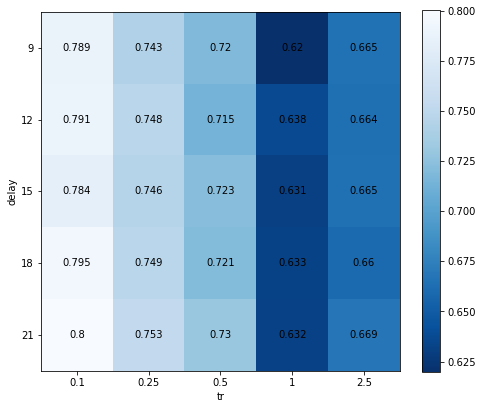

In [51]:
cv_mat = cv_arr.reshape(5, 5)
# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=cv_mat, cmap='Blues_r') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# axis titles
ax.set_xlabel('tr')
ax.set_ylabel('delay')
# show all ticks...
ax.set_xticks(np.arange(len(grid['tr'])))
ax.set_yticks(np.arange(len(grid['delay'])))
# ...and label them
ax.set_xticklabels(grid['tr'])
ax.set_yticklabels(grid['delay'])
# loop over data dimensions and create text annotations
for i in range(len(grid['tr'])):
  for j in range(len(grid['delay'])):
    text = ax.text(j, i, round(cv_mat[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [52]:
def initial_model(region, tr=.1, delay=15, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, None, None, tr, delay, gr)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [53]:
coef = []; r_sq = [];
for k in cc_dict.keys():
  m_k, X_k, y_k, r_k = initial_model(k)
  coef.append(m_k.coef_[:-1])
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameteres. It is obtained from the training data.

In [54]:
np.asarray(r_sq).mean()

0.6516493356831843

In [55]:
for r_i in r_sq:
  print(round(r_i, 2))

0.8
0.83
-2.28
0.95
0.65
0.82
0.94
0.92
0.86
0.95
0.95
0.97
0.88
0.89


Global effect of each policy.

In [56]:
coef = np.asarray(coef).mean(axis=0)
for string, value in zip(idch, coef):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> -0.014037
Workplace closing                 -> -0.018246
Cancel public events              -> -0.030902
Restrictions on gatherings        -> -0.009329
Close public transport            -> -0.006151
Stay at home requirements         -> -0.011455
Restrictions on internal movement -> -0.015335
International travel controls     -> -0.001570
Public information campaigns      -> -0.056952
Facial Coverings                  -> -0.013083


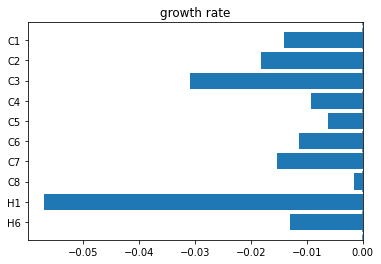

In [57]:
plt.barh(chx_str[::-1], coef[::-1]) # flip order
plt.axvline(ls='--')
plt.title('growth rate')
plt.show()

In [58]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Textual representation of the model for one country.

In [59]:
idx = 10 # country index
cci = list(cc_dict.keys())[idx]
initial_model(cci, print=True)

Coefficients
------------
C1 : -0.031204
C2 : -0.076663
C5 : -0.052648
C6 : -0.000000
C7 : -0.077490
prev : 0.562508

R^2
---
0.948


Visual representation of the model.

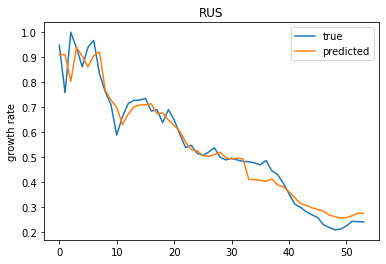

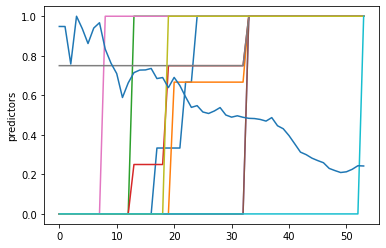


Number of data points: 54
Number of variables: 11


In [60]:
model, X, y = initial_model(cci)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', X.shape[0])
print('Number of variables:', X.shape[1])

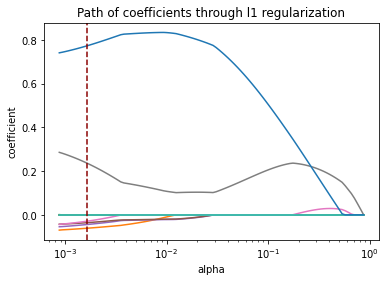

In [61]:
alphas, coefs = model.path(X, y)[:2]
alpha = model.get_params()['alpha']
for coef in coefs:
  plt.semilogx(alphas, coef)
plt.axvline(alpha, ls='--', color='darkred')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.title('Path of coefficients through l1 regularization')
plt.show()

## Transmission analysis

Parameter grid search.

In [62]:
# mm-dd-yyyy format
t_init = pd.to_datetime('06-01-2020')
t_end = t_init + pd.to_timedelta(60, unit='days')

In [63]:
y_df = beta
cv_arr = []
grid = range(7, 21) # delay
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([ 7.57494985e-01,  7.53792914e-01,  7.53242360e-01,  7.50940754e-01,
       -1.95650506e+21,  7.56296634e-01,  7.61460317e-01,  7.57647853e-01,
        7.60691857e-01,  7.64690557e-01,  7.63590167e-01,  7.62061869e-01,
        7.50887902e-01,  7.57464251e-01])

In [64]:
cv_arr.mean()

-1.3975036158141909e+20

In [65]:
y_df = beta
cv_arr = []
grid = range(1, 21) # delay
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.78465799, 0.76163538, 0.76459697, 0.77014057, 0.75538144,
       0.7732403 , 0.78388467, 0.78089637, 0.77228924, 0.7722652 ,
       0.76789867, 0.77043033, 0.77139894, 0.7685182 , 0.7713286 ,
       0.75942079, 0.75907115, 0.75768484, 0.77226755, 0.75896409])

In [66]:
cv_arr.mean()

0.7687985657722362

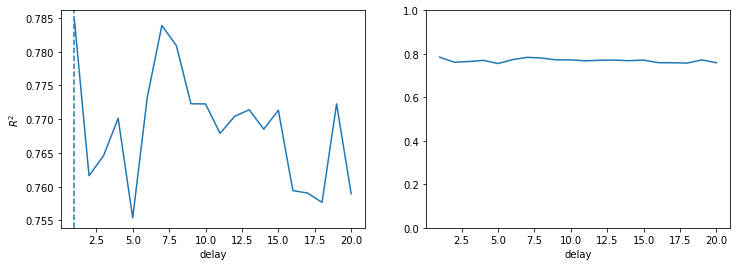

In [67]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(grid, cv_arr)
axs[0].axvline(grid[cv_arr.argmax()], ls='--')
axs[0].set_xlabel('delay')
axs[0].set_ylabel('$R^2$')
axs[1].plot(grid, cv_arr, scaley=False)
axs[1].set_xlabel('delay')
plt.show()

In [68]:
def linear_model(region, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = pd.date_range(start=ta_i, end=tb, freq='2M')

  X = []; y = []; reg = []; score = []; coef_values = []
  # apply the model to each subrange
  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    lasso.fit(X_train, y_train)
    score_i = lasso.score(X_test, y_test)

    reg_i = Lasso(alpha=lasso.alpha_).fit(X_i, y_i)
    coef_values_i = reg_i.coef_
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    reg.append(reg_i)
    coef_values.append(coef_values_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef_values).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [69]:
coef_glob = []; coef_intv = []; r_sq = [];
for k in cc_dict.keys():
  m_k, X_k, y_k, r_k = linear_model(k)
  # each model is defined in segments (invervals)
  coef_k = [lasso.coef_[:-1] for lasso in m_k]
  coef_glob.append(np.asarray(coef_k).mean(axis=0)) # aggregate
  coef_intv.append(list(coef_k))                    # individual
  r_sq.append(r_k)

Performance ($R^2$) for the chosen parameters. Is computed from the testing set.

In [70]:
np.asarray(r_sq).mean()

0.7758306460197579

In [71]:
for r_i in r_sq:
  print(round(r_i, 2))

0.71
0.9
0.86
0.76
0.97
0.87
0.6
0.83
0.85
0.66
0.89
0.45
0.56
0.95


*Global* values for the coefficients of each policy type.

In [72]:
coef_glob = np.asarray(coef_glob).mean(axis=0)
for string, value in zip(idch, coef_glob):
  name = string.split('_')[1]
  print(f'{name:33} -> {value:5f}')

School closing                    -> 0.000672
Workplace closing                 -> 0.001641
Cancel public events              -> -0.003649
Restrictions on gatherings        -> -0.008549
Close public transport            -> 0.001903
Stay at home requirements         -> 0.002092
Restrictions on internal movement -> 0.001874
International travel controls     -> 0.007270
Public information campaigns      -> -0.000511
Facial Coverings                  -> -0.002073


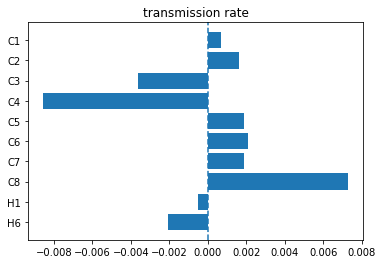

In [73]:
plt.barh(chx_str[::-1], coef_glob[::-1]) # flip order
plt.axvline(ls='--')
plt.title('transmission rate')
plt.show()

*Interval*-wise values for the coefficients of each policy type. They are meant to represent the coefficients at different stages of the pandemic.

In [74]:
# can't convert to array directly: variable interval size
# (arrays have fixed length)
# need to traverse the whole nested list
n = len(coef_intv)         # fixed lenght
m = np.zeros(n, dtype=int) # variable lenght
for i in range(n):
  m[i] = len(coef_intv[i])
# link different-lenght arrays with dictionary
dim = m.max() # dictionary size
d = {}
for a in range(dim):
  d['coef_int_{}'.format(a)] = []
# populate the arrays
for i in range(n):
  for j in range(m[i]):
    d['coef_int_{}'.format(j)].append(coef_intv[i][j])

The dictionary is contains the coefficients of the different intervals ordered by country (`axis=0`) and type (`axis=1`).

In [75]:
for a in range(dim):
  d['coef_int_{}'.format(a)] = np.array(d['coef_int_{}'.format(a)]).mean(axis=0)

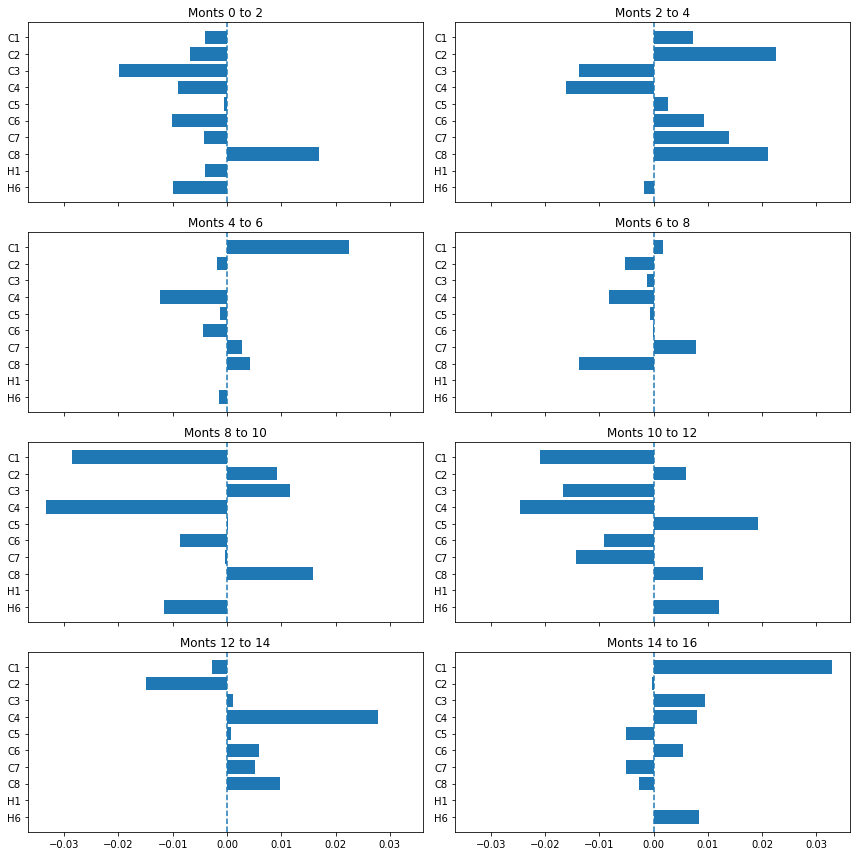

In [76]:
fig, axs = plt.subplots(nrows=dim//2, ncols=2, sharex=True, figsize=(12, 12))
# don't use the last interval with only one sample
for a in range(dim-1):
  axs[a//2, a%2].barh(chx_str[::-1], d['coef_int_{}'.format(a)][::-1]) # flip
  axs[a//2, a%2].axvline(ls='--')
  axs[a//2, a%2].set_title('Monts {} to {}'.format(a*2, (a+1)*2))
fig.tight_layout()
fig.show()

In [77]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Textual representation of single country model.

In [78]:
idx = 3 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C1 : -0.000209
C2 : 0.022250
C3 : -0.007602
C4 : -0.033277
C5 : 0.002153
C6 : -0.007522
C7 : 0.009851
H6 : 0.009576
prev : 0.785358

R^2
---
0.76


Resulting predictions of the model.

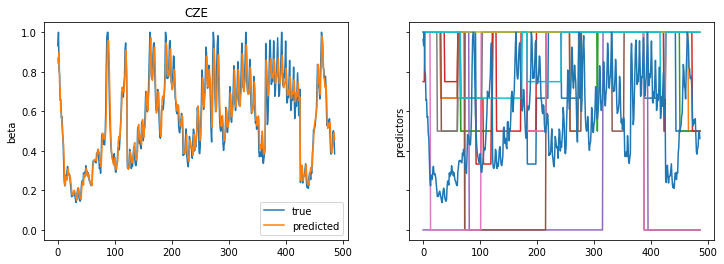

In [79]:
models, Xs, ys = linear_model(cci)[:3]

preds = []
for model, X, y in zip(models, Xs, ys):
  pred_i = model.predict(X)
  preds.append(pred_i)

# array format
X = np.vstack(Xs)
y = np.concatenate(ys)
pred = np.concatenate(preds)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
axs[0].plot(y, label='true')
axs[0].plot(pred, label='predicted')
axs[0].set_ylabel('beta')
axs[0].set_title(cci)
axs[0].legend()
axs[1].plot(X)
axs[1].set_ylabel('predictors')
plt.show()

## Trials

Efficiency of applying weights to policy indicators in accordance to the proportion of the population who is affected by the policies.

In [80]:
tot_dict = {
    code: name for code, name in zip(
        oxcgrt_sub['CountryCode'].unique(), 
        oxcgrt_sub['CountryName'].unique()
    )
}
tot_dict['USA'] = 'US'
tot_dict

{'BRA': 'Brazil',
 'CAN': 'Canada',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'USA': 'US'}

In [81]:
sub_dict = {rc: rc.split('_')[0] for rc in oxcgrt_sub['RegionCode'].unique()}
for key in sub_dict.keys():
  # correct country codes
  sub_dict[key] = sub_dict[key].replace('BR', 'BRA')
  sub_dict[key] = sub_dict[key].replace('UK', 'GBR')
  sub_dict[key] = sub_dict[key].replace('US', 'USA')
sub_dict

{'BR_AC': 'BRA',
 'BR_AL': 'BRA',
 'BR_AM': 'BRA',
 'BR_AP': 'BRA',
 'BR_BA': 'BRA',
 'BR_CE': 'BRA',
 'BR_DF': 'BRA',
 'BR_ES': 'BRA',
 'BR_GO': 'BRA',
 'BR_MA': 'BRA',
 'BR_MG': 'BRA',
 'BR_MS': 'BRA',
 'BR_MT': 'BRA',
 'BR_PA': 'BRA',
 'BR_PB': 'BRA',
 'BR_PE': 'BRA',
 'BR_PI': 'BRA',
 'BR_PR': 'BRA',
 'BR_RJ': 'BRA',
 'BR_RN': 'BRA',
 'BR_RO': 'BRA',
 'BR_RR': 'BRA',
 'BR_RS': 'BRA',
 'BR_SC': 'BRA',
 'BR_SE': 'BRA',
 'BR_SP': 'BRA',
 'BR_TO': 'BRA',
 'CAN_AB': 'CAN',
 'CAN_BC': 'CAN',
 'CAN_MB': 'CAN',
 'CAN_NB': 'CAN',
 'CAN_NL': 'CAN',
 'CAN_NS': 'CAN',
 'CAN_NT': 'CAN',
 'CAN_NU': 'CAN',
 'CAN_ON': 'CAN',
 'CAN_PE': 'CAN',
 'CAN_QC': 'CAN',
 'CAN_SK': 'CAN',
 'CAN_YT': 'CAN',
 'CHN_AH': 'CHN',
 'CHN_BJ': 'CHN',
 'CHN_CQ': 'CHN',
 'CHN_FJ': 'CHN',
 'CHN_GD': 'CHN',
 'CHN_GS': 'CHN',
 'CHN_GX': 'CHN',
 'CHN_GZ': 'CHN',
 'CHN_HA': 'CHN',
 'CHN_HB': 'CHN',
 'CHN_HE': 'CHN',
 'CHN_HI': 'CHN',
 'CHN_HL': 'CHN',
 'CHN_HN': 'CHN',
 'CHN_JL': 'CHN',
 'CHN_JS': 'CHN',
 'CHN_JX': 'CHN',
 

In [82]:
for code, name in zip(oxcgrt_sub['RegionCode'].unique(), oxcgrt_sub['RegionName'].unique()):
  print(code, '<->', name)

BR_AC <-> Acre
BR_AL <-> Alagoas
BR_AM <-> Amazonas
BR_AP <-> Amapa
BR_BA <-> Bahia
BR_CE <-> Ceara
BR_DF <-> Distrito Federal
BR_ES <-> Espirito Santo
BR_GO <-> Goias
BR_MA <-> Maranhao
BR_MG <-> Minas Gerais
BR_MS <-> Mato Grosso do Sul
BR_MT <-> Mato Grosso
BR_PA <-> Para
BR_PB <-> Paraiba
BR_PE <-> Pernambuco
BR_PI <-> Piaui
BR_PR <-> Parana
BR_RJ <-> Rio de Janeiro
BR_RN <-> Rio Grande do Norte
BR_RO <-> Rondonia
BR_RR <-> Roraima
BR_RS <-> Rio Grande do Sul
BR_SC <-> Santa Catarina
BR_SE <-> Sergipe
BR_SP <-> Sao Paulo
BR_TO <-> Tocantins
CAN_AB <-> Alberta
CAN_BC <-> British Columbia
CAN_MB <-> Manitoba
CAN_NB <-> New Brunswick
CAN_NL <-> Newfoundland and Labrador
CAN_NS <-> Nova Scotia
CAN_NT <-> Northwest Territories
CAN_NU <-> Nunavut
CAN_ON <-> Ontario
CAN_PE <-> Prince Edward Island
CAN_QC <-> Quebec
CAN_SK <-> Saskatchewan
CAN_YT <-> Yukon
CHN_AH <-> Anhui
CHN_BJ <-> Beijing
CHN_CQ <-> Chongqing
CHN_FJ <-> Fujian
CHN_GD <-> Guangdong
CHN_GS <-> Gansu
CHN_GX <-> Guangxi
CHN

In [83]:
# https://worldpopulationreview.com/countries
tot_pop = {
    'BRA': 212559417,
    'CAN': 37742154,
    'CHN': 1439323776,
    'GBR': 67886011,
    'USA': 331002651
}

# https://en.wikipedia.org/wiki/List_of_Brazilian_states_by_population
# https://worldpopulationreview.com/canadian-provinces
# https://en.wikipedia.org/wiki/List_of_Chinese_administrative_divisions_by_population
# https://en.wikipedia.org/wiki/Countries_of_the_United_Kingdom_by_population (2019)
# https://worldpopulationreview.com/states (2021)
sub_pop = {
    'BR_AC': 894470, 'BR_AL': 3351543, 'BR_AM': 4207714,
    'BR_AP': 861773, 'BR_BA': 14930634, 'BR_CE': 9187103,
    'BR_DF': 3055149, 'BR_ES': 4064052, 'BR_GO': 7113540,
    'BR_MA': 7114598, 'BR_MG': 21292666, 'BR_MS': 2809394,
    'BR_MT': 3526220, 'BR_PA': 8690745, 'BR_PB': 4039277,
    'BR_PE': 9616621, 'BR_PI': 3281480, 'BR_PR': 11516840,
    'BR_RJ': 17366189, 'BR_RN': 3534165, 'BR_RO': 1796460,
    'BR_RR': 631181, 'BR_RS': 11422973, 'BR_SC': 7252502,
    'BR_SE': 2318822, 'BR_SP': 46289333, 'BR_TO': 1590248,
    'CAN_AB': 4428112, 'CAN_BC': 5145851, 'CAN_MB': 1379584,
    'CAN_NB': 781315, 'CAN_NL': 520998, 'CAN_NS': 979115,
    'CAN_NT': 45074, 'CAN_NU': 39285, 'CAN_ON': 14733119,
    'CAN_PE': 159713, 'CAN_QC': 8575779, 'CAN_SK': 1177884,
    'CAN_YT': 42176, 'CHN_AH': 61027171, 'CHN_BJ': 21893095,
    'CHN_CQ': 32054159, 'CHN_FJ': 41540086, 'CHN_GD': 126012510,
    'CHN_GS': 25019831, 'CHN_GX': 50126804, 'CHN_GZ': 38562148,
    'CHN_HA': 99365519, 'CHN_HB': 57752557, 'CHN_HE': 74610235,
    'CHN_HI': 10081232, 'CHN_HL': 31850088, 'CHN_HN': 66444864,
    'CHN_JL': 24073453, 'CHN_JS': 84748016, 'CHN_JX': 45188635,
    'CHN_LN': 42591407, 'CHN_NM': 24049155, 'CHN_NX': 7202654,
    'CHN_QH': 5923957, 'CHN_SC': 83674866, 'CHN_SD': 101527453,
    'CHN_SH': 24870895, 'CHN_SN': 39528999, 'CHN_SX': 34915616,
    'CHN_TJ': 13866009, 'CHN_XJ': 25852345, 'CHN_XZ': 3648100,
    'CHN_YN': 47209277, 'CHN_ZJ': 64567588, 'UK_ENG': 56286961,
    'UK_NIR': 1893667, 'UK_SCO': 5463300, 'UK_WAL': 3152879	,
    'US_AK': 724357, 'US_AL': 4934193, 'US_AR': 3033946,
    'US_AZ': 7520103, 'US_CA': 39613493, 'US_CO': 5893634,
    'US_CT': 3552821, 'US_DC': 714153, 'US_DE': 990334,
    'US_FL': 21944577, 'US_GA': 10830007, 'US_HI': 1406430,
    'US_IA': 3167974, 'US_ID': 1860123, 'US_IL': 12569321,
    'US_IN': 6805663, 'US_KS': 2917224, 'US_KY': 4480713,
    'US_LA': 4627002, 'US_MA': 6912239, 'US_MD': 6065436,
    'US_ME': 1354522, 'US_MI': 9992427, 'US_MN': 5706398,
    'US_MO': 6169038, 'US_MS': 2966407, 'US_MT': 1085004,
    'US_NC': 10701022, 'US_ND': 770026, 'US_NE': 1951996,
    'US_NH': 1372203, 'US_NJ': 8874520, 'US_NM': 2105005,
    'US_NV': 3185786, 'US_NY': 19299981, 'US_OH': 11714618,
    'US_OK': 3990443, 'US_OR': 4289439, 'US_PA': 12804123,
    'US_RI': 1061509, 'US_SC': 5277830, 'US_SD': 896581,
    'US_TN': 6944260, 'US_TX': 29730311, 'US_UT': 3310774,
    'US_VA': 8603985, 'US_VT': 623251, 'US_WA': 7796941,
    'US_WI': 5852490, 'US_WV': 1767859, 'US_WY': 581075
}

In [84]:
sub_prop = {rc: sub_pop[rc] / tot_pop[cc] for rc, cc in sub_dict.items()}
sub_prop

{'BR_AC': 0.004208093965556934,
 'BR_AL': 0.015767558301121986,
 'BR_AM': 0.01979547205852564,
 'BR_AP': 0.004054268741243302,
 'BR_BA': 0.07024216668791484,
 'BR_CE': 0.043221340788679334,
 'BR_DF': 0.014373152895879461,
 'BR_ES': 0.019119604566849184,
 'BR_GO': 0.0334661249094412,
 'BR_MA': 0.03347110234123384,
 'BR_MG': 0.10017277192663734,
 'BR_MS': 0.013216982054481265,
 'BR_MT': 0.016589337935566505,
 'BR_PA': 0.04088619136549476,
 'BR_PB': 0.01900304892161047,
 'BR_PE': 0.04524203695948225,
 'BR_PI': 0.01543794222958374,
 'BR_PR': 0.05418174439196923,
 'BR_RJ': 0.08170039815267277,
 'BR_RN': 0.016626715719680395,
 'BR_RO': 0.008451566274290261,
 'BR_RR': 0.002969433247928037,
 'BR_RS': 0.053740140809663585,
 'BR_SC': 0.034119880936632416,
 'BR_SE': 0.010909053255448099,
 'BR_SP': 0.21777126439897979,
 'BR_TO': 0.007481428122283569,
 'CAN_AB': 0.1173253651606636,
 'CAN_BC': 0.13634227129696944,
 'CAN_MB': 0.036552868710143044,
 'CAN_NB': 0.020701388691276072,
 'CAN_NL': 0.0138041

In [85]:
# REPEAT COMPUTATION OF LABELS
cum_cases_alt = jhu_cases[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths_alt = jhu_death[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries_alt = jhu_recov[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()

R_alt = cum_deaths_alt + cum_recoveries_alt
I_alt = cum_cases_alt - R_alt
S_alt = tot_pop.values() - cum_cases_alt

i_prop_alt = I_alt / tot_pop.values()
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i_alt = np.log(i_prop_alt)
warnings.resetwarnings()
log_i_alt[np.isinf(log_i_alt)] = 0 # before the pandemic begins, the growth must be zero
gr_alt = log_i_alt[1:] - log_i_alt[:-1].values # different index
gr_alt

Country/Region,Brazil,Canada,China,United Kingdom,US
2020-01-23,0.000000,0.000000,0.229565,0.000000,0.117783
2020-01-24,0.000000,-19.055726,0.247127,0.000000,0.382992
2020-01-25,0.000000,0.693147,0.354482,0.000000,0.310155
2020-01-26,0.000000,0.693147,0.485826,0.000000,0.236389
2020-01-27,0.000000,0.405465,0.342863,0.000000,0.191055
...,...,...,...,...,...
2021-10-08,0.000712,0.001857,0.000268,0.004012,0.001771
2021-10-09,0.000610,0.001529,0.000243,0.004181,0.001796
2021-10-10,0.000534,0.001971,0.000237,0.004258,0.001821
2021-10-11,0.000263,0.000641,0.000128,0.001627,0.000582


Steps to apply the weights;
1. Pivot the original df and construct multilevel columns with region and country.
2. Convert to boolean type to obtain a binary representation.
3. Multiply by the proportional population
4. Stack the region column and group by date, which is equivalent to sum up the proportion of each region.

In [86]:
C1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[0])
C2_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[1])
C3_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[2])
C4_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[3])
C5_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[4])
C6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[5])
C7_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[6])
C8_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[7])
H1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[8])
H6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[9])

C1_bin = C1_sub.astype(bool) * sub_prop.values()
C2_bin = C2_sub.astype(bool) * sub_prop.values()
C3_bin = C3_sub.astype(bool) * sub_prop.values()
C4_bin = C4_sub.astype(bool) * sub_prop.values()
C5_bin = C5_sub.astype(bool) * sub_prop.values()
C6_bin = C6_sub.astype(bool) * sub_prop.values()
C7_bin = C7_sub.astype(bool) * sub_prop.values()
C8_bin = C8_sub.astype(bool) * sub_prop.values()
H1_bin = H1_sub.astype(bool) * sub_prop.values()
H6_bin = H6_sub.astype(bool) * sub_prop.values()

C1_weights = C1_bin.stack().groupby('Date').sum()
C2_weights = C2_bin.stack().groupby('Date').sum()
C3_weights = C3_bin.stack().groupby('Date').sum()
C4_weights = C4_bin.stack().groupby('Date').sum()
C5_weights = C5_bin.stack().groupby('Date').sum()
C6_weights = C6_bin.stack().groupby('Date').sum()
C7_weights = C7_bin.stack().groupby('Date').sum()
C8_weights = C8_bin.stack().groupby('Date').sum()
H1_weights = H1_bin.stack().groupby('Date').sum()
H6_weights = H6_bin.stack().groupby('Date').sum()

CH_w = [
        C1_weights, C2_weights, C3_weights, C4_weights, C5_weights,
        C6_weights, C7_weights, C8_weights, H1_weights, H6_weights
]

Comparison between the fits with and without applying weights.

In [87]:
def data_from_alt(iso, tr, t_d, y, weight):
  'Select data with location and time constraints.'

  if iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  t0 = cum_cases_alt.loc[cum_cases_alt[name] > 25, name].index.min()
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  prop_case = cum_cases_alt[name] / tot_pop[iso]
  t1 = prop_case[prop_case < tr/100].index.max()
  
  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  if weight:
    # apply policy weights
    ch_w = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_w]
    w_t = pd.concat(ch_w, axis=1, ignore_index=True)
    pol_t *= w_t
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

In [88]:
def initial_model_weighted(region, tr=1, delay=12, weighted=True, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - weighted (bool) : wheter to apply weights to the policies.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from_alt(region, tr, delay, gr_alt, weighted)
  X, y = preprocess(X_raw, y_raw) 
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

Don't apply weights

In [89]:
r_sq = [initial_model_weighted(k, weighted=False)[3] for k in tot_dict.keys()]
np.asarray(r_sq).mean()

0.05251838005032683

In [90]:
idx = 1 # country index
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, weighted=False, print=True)

Coefficients
------------
C1 : -0.052416
C4 : -0.038498
C7 : -0.126662
prev : 0.031165

R^2
---
0.568


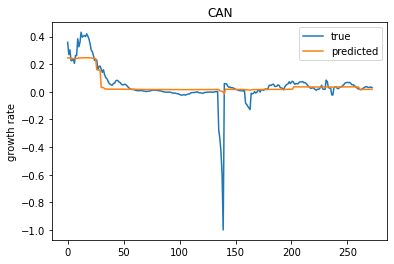

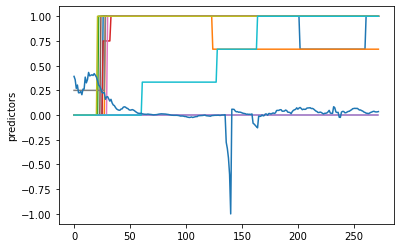

In [91]:
model, X, y = initial_model_weighted(cci, weighted=False)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

Apply weights

In [92]:
r_sq = [initial_model_weighted(k, weighted=True)[3] for k in tot_dict.keys()]
np.asarray(r_sq).mean()

0.01729849706937179

In [93]:
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, print=True)

Coefficients
------------
C1 : -0.039289
C4 : -0.176388
prev : 0.036041

R^2
---
0.57


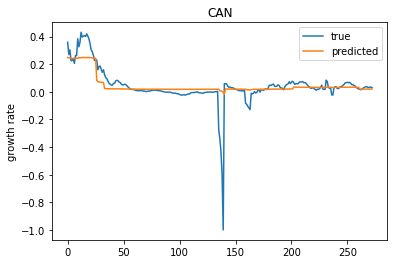

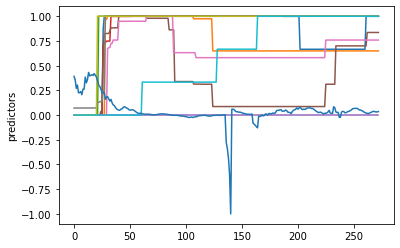

In [94]:
model, X, y = initial_model_weighted(cci)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()